In [45]:
import pandas as pd
# from google.colab import drive
import os
import re
# import optuna.integration.lightgbm as lgb

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

#訓練データとモデル評価用データに分けるライブラリ
from sklearn.model_selection import train_test_split

In [46]:
train = pd.read_csv('train.tsv', index_col=0, sep="\t") # 学習用データ
test = pd.read_csv('test.tsv', index_col=0, sep="\t") # 学習用データ
submit = pd.read_csv('sample_submit.tsv' , header=None, sep="\t") # 応募用サンプルファイル

In [47]:
train

,survived,pclass,sex,age,sibsp,parch,fare,embarked
id,,,,,,,,
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
7,0,3,male,2.0,3,1,21.0750,S
9,1,2,female,14.0,1,0,30.0708,C
11,1,1,female,58.0,0,0,26.5500,S
...,...,...,...,...,...,...,...,...
873,0,3,male,47.0,0,0,9.0000,S
874,1,2,female,28.0,1,0,24.0000,C
879,1,1,female,56.0,0,1,83.1583,C


In [48]:
print(train[:20].corr())

          survived    pclass       age     sibsp     parch      fare
survived  1.000000 -0.404520  0.093493 -0.342997 -0.033059  0.310208
pclass   -0.404520  1.000000 -0.378600  0.173436  0.245172 -0.637611
age       0.093493 -0.378600  1.000000 -0.745342 -0.014518 -0.223947
sibsp    -0.342997  0.173436 -0.745342  1.000000  0.283478  0.385953
parch    -0.033059  0.245172 -0.014518  0.283478  1.000000  0.388986
fare      0.310208 -0.637611 -0.223947  0.385953  0.388986  1.000000


C:\Users\daich\AppData\Local\Temp\ipykernel_5396\633831175.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(train[:20].corr())


#特徴量エンジニアリング1

In [49]:
from sklearn.preprocessing import LabelEncoder
 
le = LabelEncoder()
le.fit(train['sex'])
train['sex'] = le.transform(train['sex']).astype("int")

le.fit(train['embarked'])
train['embarked'] = le.transform(train['embarked']).astype("int")

le.fit(test['sex'])
test['sex'] = le.transform(test['sex']).astype("int")

le.fit(test['embarked'])
test['embarked'] = le.transform(test['embarked']).astype("int")

train

,survived,pclass,sex,age,sibsp,parch,fare,embarked
id,,,,,,,,
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2
7,0,3,1,2.0,3,1,21.0750,2
9,1,2,0,14.0,1,0,30.0708,0
11,1,1,0,58.0,0,0,26.5500,2
...,...,...,...,...,...,...,...,...
873,0,3,1,47.0,0,0,9.0000,2
874,1,2,0,28.0,1,0,24.0000,0
879,1,1,0,56.0,0,1,83.1583,0


In [50]:
train.dtypes

survived      int64
pclass        int64
sex           int32
age         float64
sibsp         int64
parch         int64
fare        float64
embarked      int32
dtype: object

In [56]:
test

,pclass,sex,age,sibsp,parch,fare,embarked
0,3,1,22.0,1,0,7.2500,2
1,1,0,38.0,1,0,71.2833,0
2,3,0,26.0,0,0,7.9250,2
3,3,1,NaN,0,0,8.4583,1
4,1,1,54.0,0,0,51.8625,2
...,...,...,...,...,...,...,...
441,3,0,39.0,0,5,29.1250,1
442,2,1,27.0,0,0,13.0000,2
443,1,0,19.0,0,0,30.0000,2
444,1,1,26.0,0,0,30.0000,0


In [52]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
train

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,1,1,0,35.0,1,0,53.1000,2
1,0,3,1,35.0,0,0,8.0500,2
2,0,3,1,2.0,3,1,21.0750,2
3,1,2,0,14.0,1,0,30.0708,0
4,1,1,0,58.0,0,0,26.5500,2
...,...,...,...,...,...,...,...,...
440,0,3,1,47.0,0,0,9.0000,2
441,1,2,0,28.0,1,0,24.0000,0
442,1,1,0,56.0,0,1,83.1583,0
443,0,3,1,25.0,0,0,7.0500,2


In [61]:
from sklearn.model_selection import StratifiedKFold

NUM_FOLD = 5
train["fold"] = 0

kf = StratifiedKFold(n_splits=NUM_FOLD, random_state=2022, shuffle=True)
for i, (train_idx, val_idx) in enumerate(kf.split(train, train["survived"])):
    print(train_idx)
    print(val_idx)
    train.loc[val_idx, "fold"] = int(i)

[  1   2   3   4   5   6   7   8   9  10  11  12  15  16  17  20  21  22
  23  24  25  26  27  29  31  33  34  35  36  39  40  41  42  43  44  45
  47  48  49  50  53  54  56  57  58  60  61  62  63  65  66  67  68  69
  70  71  72  73  74  77  78  79  80  83  84  85  86  87  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 125 127 128 129 131 132
 133 134 137 138 140 141 142 143 144 145 146 147 148 149 150 153 154 156
 159 161 162 163 164 165 166 167 168 170 171 172 174 175 176 177 178 179
 180 181 182 183 184 185 187 189 190 191 192 193 194 198 199 200 202 203
 205 207 208 209 210 211 212 213 214 215 217 218 219 221 222 223 224 227
 228 230 232 233 235 236 237 238 240 241 242 243 244 245 246 247 248 249
 250 251 252 253 255 257 259 261 262 263 264 265 268 269 271 272 273 274
 275 276 277 279 280 281 283 284 285 286 287 288 289 290 291 292 293 294
 295 296 297 298 299 300 301 302 303 304 305 306 30

In [54]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

def cal_rmse(y_true, y_pred):
  return roc_auc_score(y_true, y_pred)

In [66]:
# !pip uninstall --yes lightgbm && pip install --install-option=--gpu lightgbm

lgb_fit_params ={'num_boost_rounds': 10000,
                 'early_stopping_rounds': 100,
                 'verbose_eval': 100,
                }


lgb_model_params = {'boosting_type': 'gbdt',
                    'device': 'gpu', 
                    'objective': 'binary',
                    'learning_rate': 0.05,
                    'max_depth': -1,
                    'num_leaves': 72,
                    'min_data_in_leaf': 20,
                    'max_bin': 255,
                    'verbose': -1,
                    'n_jobs': -1,
                    'feature_pre_filter': False,
                    'bagging_fraction': 0.9918357136100413,
                    'bagging_freq': 4,
                    'feature_fraction': 0.9840000000000001,
                    'lambda_l1': 7.386178645626934,
                    'lambda_l2': 4.572888900518312e-08,
                    'min_child_samples': 20}

In [67]:

callbacks = [
  lgb.early_stopping(stopping_rounds=1000, verbose=False),
  lgb.log_evaluation(1000)
]

models = []
cv_scores = []
test_preds = []


for i in range(1):
    print(f"\nFOLD {i}")
    train_df = train[train["fold"]!=i]
    val_df = train[train["fold"]==i]

    X_train, y_train = train_df.drop(columns=["survived", "fold"]), train_df["survived"].values
    X_val, y_val = val_df.drop(columns=["survived", "fold"]), val_df["survived"].values
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val)
    
    model = lgb.train(lgb_model_params,
                       train_set=lgb_train,
                       valid_sets=[lgb_train, lgb_eval],
                       verbose_eval=lgb_fit_params['verbose_eval'],
                       num_boost_round=lgb_fit_params['num_boost_rounds'],
                       callbacks=[lgb.early_stopping(lgb_fit_params['early_stopping_rounds'])],
                       )
    
    models.append(model) # 一応取っておく

    val_pred = model.predict(X_val)
    # score = balanced_log_loss(y_val, val_pred)
    score = cal_rmse(y_val, val_pred)
    cv_scores.append(score)
    print(score)

    test_preds.append(model.predict(test))
cv_log_loss = sum(cv_scores)/NUM_FOLD
print(cv_log_loss)


FOLD 0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.445423	valid_1's binary_logloss: 0.441467
[200]	training's binary_logloss: 0.444792	valid_1's binary_logloss: 0.441295
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.444925	valid_1's binary_logloss: 0.441235
0.8616352201257863
0.17232704402515725


#学習


In [68]:
def visualize_importance(models, feat_train_df, file_name):
    
    feature_importance_df = pd.DataFrame()

    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance(importance_type='gain')
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0,
                                          ignore_index=True
                                         )
    
    mean_feature_importance = feature_importance_df.groupby('column').mean().sort_values('feature_importance', ascending=False)
    
    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:30]
    
    fig, ax = plt.subplots(figsize=(12, max(8, len(order) * 0.25)))
    sns.boxenplot(data=feature_importance_df,
                  x='feature_importance',
                  y='column',
                  order=order,
                  ax=ax,
                  palette='viridis',
                  orient='h'
                 )
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig, ax, order

C:\Users\daich\AppData\Local\Temp\ipykernel_5396\1349645175.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importances = feature_importances.append(tmp)


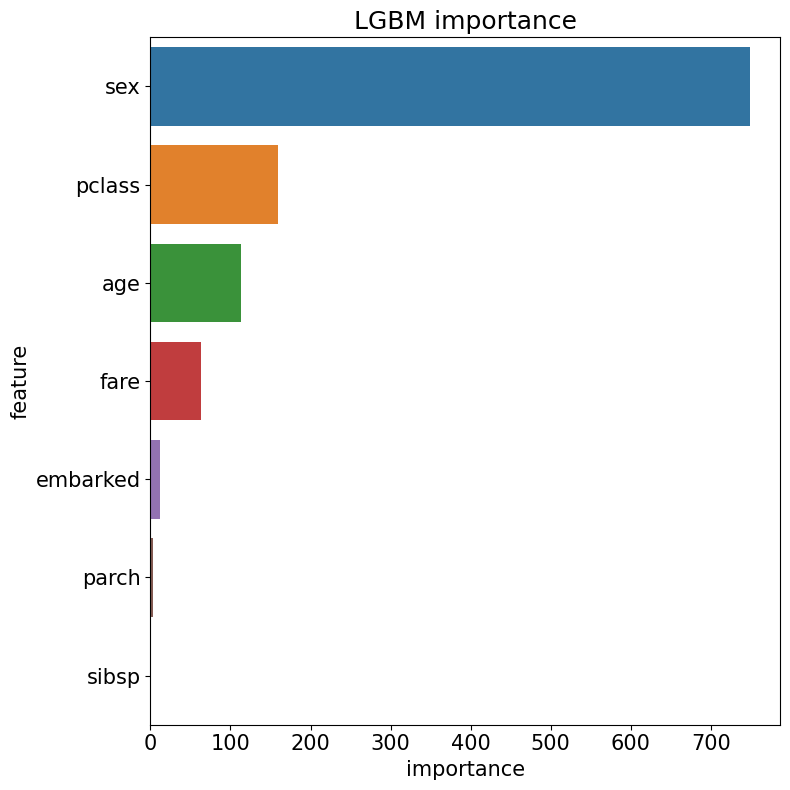

In [84]:
feature_importances = pd.DataFrame()

for fold, model in enumerate(models):

    tmp = pd.DataFrame()
    tmp['feature'] = model.feature_name()
    tmp['importance'] = model.feature_importance(importance_type='gain')
    tmp['fold'] = fold

    feature_importances = feature_importances.append(tmp)

order = list(feature_importances.groupby("feature")["importance"].mean().sort_values(ascending=False).index)

plt.figure(figsize=(8, 8))
sns.barplot(x='importance', y='feature', data=feature_importances, order=order)
plt.title('LGBM importance')
plt.rcParams["font.size"] = 10

plt.tight_layout()

plt.show()

In [71]:
train

,survived,pclass,sex,age,sibsp,parch,fare,embarked,fold
0,1,1,0,35.0,1,0,53.1000,2,0
1,0,3,1,35.0,0,0,8.0500,2,1
2,0,3,1,2.0,3,1,21.0750,2,4
3,1,2,0,14.0,1,0,30.0708,0,1
4,1,1,0,58.0,0,0,26.5500,2,4
...,...,...,...,...,...,...,...,...,...
440,0,3,1,47.0,0,0,9.0000,2,1
441,1,2,0,28.0,1,0,24.0000,0,4
442,1,1,0,56.0,0,1,83.1583,0,3
443,0,3,1,25.0,0,0,7.0500,2,3


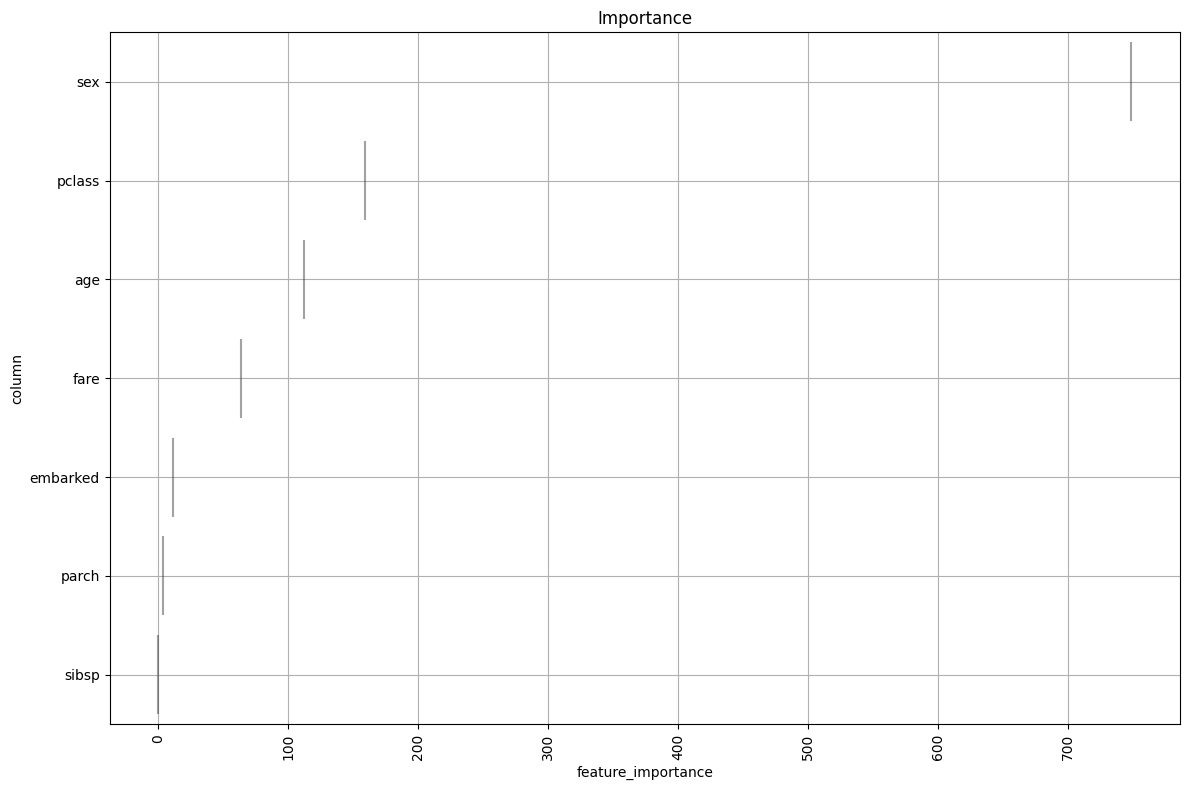

In [74]:
_ = visualize_importance(models, train.drop(columns = ["fold","survived"]), 'lgb_model')

In [ ]:
set(submission_df.columns)^set(train_df.columns)

set()

In [ ]:
submission_df

,lat,lon,area,year,month,depth_original,cliff_length,aicial_length,beach_length,coast_length,...,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,cluster,mean_01,mean_02,mean_03,near_20,near_30
0,24.352222,124.202674,20.0,2002.0,12.0,0.000000,0.000000,725.621704,306.701050,1032.322754,...,4.297234,926.905329,1.669992,0.194766,2,0.235185,0.163118,0.155034,0.05000,0.05000
1,24.420028,124.078583,20.0,2010.0,7.0,NaN,0.000000,0.000000,1421.016357,1421.016357,...,2.263106,57.661693,4.274851,-79.273275,13,0.249193,0.154995,0.189959,0.00000,0.03750
2,26.494197,127.836013,100.0,2004.0,2.0,3.257829,73.183418,80.595177,984.422791,1138.201416,...,2.099250,42.672829,5.655713,-2.061417,0,0.061607,0.154167,0.141379,0.02500,0.02500
3,26.183639,127.319361,20.0,2010.0,8.0,NaN,0.000000,0.000000,29.648212,29.648212,...,-10.433323,45.061952,1.546086,-14.527890,6,0.050000,0.050000,0.057681,0.05000,0.05000
4,24.761089,125.269009,20.0,2019.0,10.0,0.000000,0.000000,34.796036,372.873108,407.669128,...,2.563503,80.374689,1.827876,-6.335208,14,0.182487,0.114607,0.104660,0.28500,0.32000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,26.702075,127.873347,20.0,2019.0,9.0,8.721841,0.000000,20.594961,581.052856,601.647827,...,3.633575,60.936945,3.053976,-28.354402,4,0.039875,0.115070,0.283821,0.05000,0.05000
4035,24.337028,124.232694,20.0,2010.0,11.0,NaN,0.000000,0.000000,64.563194,64.563194,...,2.495430,75.231230,3.946128,-2.112646,2,0.138734,0.157913,0.156381,0.05000,0.17000
4036,26.493121,127.839918,100.0,2004.0,2.0,0.000000,76.439651,133.127228,1403.852905,1613.419800,...,4.403977,117.513676,1.904304,0.601280,0,0.060345,0.153289,0.140872,0.02500,0.02500
4037,24.068778,123.804194,20.0,2011.0,4.0,NaN,73.660492,0.000000,685.145386,758.805908,...,2.203933,121.654726,2.282056,-2.029225,7,0.225716,0.385713,0.267224,0.30932,0.17966


In [ ]:
train_df

,lat,lon,area,year,month,depth_original,cliff_length,aicial_length,beach_length,coast_length,...,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,cluster,mean_01,mean_02,mean_03,near_20,near_30
0,24.989139,125.243167,20.0,2011.0,9.0,NaN,0.000000,0.000000,0.000000,0.000000,...,2.353039,95.142525,3.728732,-2.405135,11,0.061788,0.066980,0.106918,0.050,0.05000
1,26.996172,127.912024,40.0,2009.0,7.0,NaN,0.000000,0.478772,949.173828,949.652588,...,4.672225,174.767501,-0.571513,0.448861,4,0.462640,0.447518,0.436947,0.565,0.70250
2,26.363556,127.735139,20.0,2009.0,10.0,NaN,0.000000,180.985031,521.317383,702.302429,...,3.324236,62.711236,3.284478,-57.136191,13,0.027844,0.163901,0.131431,0.025,0.02500
3,26.991255,127.912302,40.0,2009.0,1.0,NaN,0.000000,0.361444,799.384399,799.745850,...,2.988302,51.879647,6.054869,-5.697032,4,0.462208,0.447681,0.434038,0.525,0.61500
4,26.988254,127.917254,40.0,2009.0,1.0,NaN,0.000000,6.062498,954.537293,960.599793,...,2.436510,50.467718,8.537779,-1.617806,4,0.461791,0.448630,0.433660,0.855,0.78000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14135,24.728611,125.403889,20.0,2011.0,9.0,NaN,1294.458862,0.000000,56.749870,1351.208740,...,2.081548,202.985223,-497.151601,-449.711425,2,0.050383,0.142860,0.109690,0.050,0.05000
14136,27.002425,127.927444,40.0,2009.0,7.0,NaN,0.000000,88.078857,798.082642,886.161499,...,4.284944,66.766629,3.086038,-18.261736,4,0.462318,0.448618,0.442516,0.705,0.61250
14137,24.797444,125.162417,20.0,2012.0,2.0,NaN,0.000000,0.000000,594.742188,594.742188,...,2.327925,54.130453,4.699174,-15.904502,2,0.211291,0.122079,0.105826,0.050,0.05000
14138,26.999893,127.922014,40.0,2009.0,4.0,NaN,0.000000,53.709103,1355.455078,1409.164185,...,-80.506948,1016.155119,1.708610,0.329458,4,0.462276,0.448384,0.440641,0.601,0.39825


In [ ]:
score_each_model = []

# test_type = test.dtypes
# test_columns = list(test_type[(test_type == int) | (test_type == float)].index)
for CVmodel in allmodel:
    total_pred = []
    for model in CVmodel:
        pred = model.predict(submission_df)
        total_pred.append(pred)
    total_sum = np.sum(total_pred, axis=0)/len(CVmodel)
    score_each_model.append(total_sum)
    
final_score = np.sum(score_each_model, axis=0)/len(allmodel)

In [ ]:
score_each_model

[array([0.0946677 , 0.04859376, 0.24240453, ..., 0.30825024, 0.18304793,
        0.3718855 ])]

In [ ]:
final_score

array([0.0946677 , 0.04859376, 0.24240453, ..., 0.30825024, 0.18304793,
       0.3718855 ])

In [ ]:
submit.iloc[:, 1] = final_score
submit

,0,1
0,0,0.094668
1,1,0.048594
2,2,0.242405
3,3,0.061274
4,4,0.272493
...,...,...
4034,4034,0.111731
4035,4035,0.057050
4036,4036,0.308250
4037,4037,0.183048


In [ ]:
submit = submit.apply(lambda x: round(x / 0.025) * 0.025)
submit

,0,1
0,0.0,0.100
1,1.0,0.050
2,2.0,0.250
3,3.0,0.050
4,4.0,0.275
...,...,...
4034,4034.0,0.100
4035,4035.0,0.050
4036,4036.0,0.300
4037,4037.0,0.175


In [ ]:
submit.to_csv('submit/submit_050.csv',index=False,header=None)